In [22]:
import math
import random
import pandas as pd
import numpy as np

from IPython.display import clear_output
from tqdm.notebook import tqdm

In [23]:
seed = 61
random.seed(seed)
np.random.seed(seed)

In [24]:
import os
from typing import Annotated, Sequence, TypedDict, List, Dict
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools import DuckDuckGoSearchRun, Tool
from tavily import TavilyClient

### Краткое описание

В данном файле представлена одна из версий "какого-то агента", который под капотом имеет возможность обращаться к поисковой строке.  
Общая логика и архитектура сохранились и в следующих версиях, однако, в финальных версиях менялись или дорабатывались промпты на всех этапах работы агента.  
Данный агент не запускался на всей тестовой выборке, а работал на валидационном наборе данных, взятых из трейн выборки.  
В ходе работ на данном этапе выяснились ряд недостатков. Изначально предполагалась работа агента на моделях от QWEN (qwen3-32b, qwen3-235b-a22b). Обе модели с ризонингом и вроде справлялись с задачей, но слишком долго размышляли (порядка 14-17 и более мин на 100 запросов). Поэтому было принято решение отказаться от этих LLM в пользу модели без ризонинга  - deepseek-chat-v3. Однако, V3 оказалась весьма капризной к промптам и потребовала их изменений, что будет показано в разделе "финальных" агентов. 

### Загрузка данных

Для задач по работе с данным агентом был подготовлен отдельный валидационный набор данных. Загрузимся сразу из него.

In [25]:
val_data = pd.read_excel('val_100_summarized.xlsx')
val_data.drop('Unnamed: 0', axis=1, inplace=True)

In [26]:
val_data.head(2)

,text,address,name,relevance,summarized
0,макароны из фундучной муки,"Смоленск, улица Кутузова, 54",Metro; Metro Cash & Carry; Metro Cash &amp; Ca...,0,Продуктовый гипермаркет ; Продуктовый гипермар...
1,рейтинг суши баров,"Москва, Новодмитровская улица, 1с6",Такеши; Takeshi; Суши бар Takeshi; Суши-бар Та...,1,Суши-бар ; Суши-бар «Такеши» предлагает широки...


In [27]:
val_data.shape

(100, 5)

### Агент

Данный агент на Langgraph, а в качестве поиска используется Tavily. Изначально поисковиком выступал DuckDuckGo, но спустя короткое время они стали блокировать запросы. 

In [28]:
# Вызываем модель и передаем ей инструменты
load_dotenv()
model = ChatOpenAI(
    model="deepseek/deepseek-chat-v3-0324",  # Модель
    base_url="https://api.ai-mediator.ru/v1",  # Кастомный URL API
    api_key=os.getenv("OPENAI_API_KEY"),  # Ключ из переменных окружения
    temperature=0,  # Опционально, как в примере
    )

# Загружаем ключи для поисковика - TAVILY_API_KEY из .env
tavily = TavilyClient(api_key=os.getenv("TAVILY_API_KEY")) 

In [29]:
# Опишем состояние агента
class AgentState(TypedDict):
    user_query: str                # запрос пользователя
    organization_address: str      # 
    organization_name: str         # 
    summary: str                   # обобщенная инфо
    sufficiency: List[str]         # "ДОСТАТОЧНО" | "НЕДОСТАТОЧНО: <причина>"
    classification: str            # "relevant" / "irrelevant"
    additional_info: str           # additional_info - получение доп инфо в т.ч. из интернета
    number_of_requests: int
    subject_of_clarification: str  # что требуется уточнить
    search_query: str              # поисковый запрос от LLM

Раздел с промптами для 3-х этапов работы агента:  
1) Этап определения достаточно ли инфо для решения о релевантности организации запросу.
2) Этап поиска в интернете.
3) Этап классификации.

In [30]:
# Раздел с промптами

# ПРОМПТ ДЛЯ ЗАДАЧИ ОПРЕДЕЛЕНИЯ ДОСТАТОЧНОСТИ ИНФО
SUFFICIENCY_PROMPT = SystemMessage(content="""
**Задача:** Оцени, достаточно ли предоставленной информации об организации 
('Адрес', 'Название', 'Сводка' и 'Дополнительная информация'), чтобы уверенно определить 
относится ли организация к 'user_query' (ЗАПРОС ПОЛЬЗОВАТЕЛЯ): 1 - ОТНОСИТСЯ, 0 - НЕ ОТНОСИТСЯ.

**Инструкции по оценке достаточности:**
1. Определи, есть ли в запросе географические указания (город, район, адрес). Если нет - пункт 2 не применяй, поле 'Адрес' не используй.
2. Учитывай географическую принадлежность к городу (ТОЛЬКО если в запросе явно указан город):
    - если город в запросе пользователя не совпадает с городом в Адресе - этого ДОСТАТОЧНО для вывода, что организация НЕ ОТНОСИТСЯ к запросу пользователя.
3. Оцени совпадение по ключевым словам ("налоговая", "больница", ресторан и т.д.) и номеру (если цифры есть в запросе):
    а) если явно следует, что организация относится к запросу пользователя - информации "ДОСТАТОЧНО";
    б) если есть явные не совпадения и понятно, что организация НЕ ОТНОСИТСЯ к запросу пользователя - информации "ДОСТАТОЧНО"
4. Оцени случаи явного несоответсвия: если основная деятельность организации очевидно НЕ ОТНОСИТСЯ к типу объекта в запросе, информации "ДОСТАТОЧНО".
5. Оцени другие возможные критерии, исходя из которых можно сделать вывод об информации: "ДОСТАТОЧНО" или "НЕДОСТАТОЧНО".

**Твой вывод ДОЛЖЕН быть одним из вариантов:**
*   Если без дополнительных данных можно уверенно понять относится ли организация к ЗАПРОСУ ПОЛЬЗОВАТЕЛЯ (1 - ОТНОСИТСЯ, 0 - НЕ ОТНОСИТСЯ) - дай ответ в одно слово "ДОСТАТОЧНО"
*   Если информации недостаточно — выведи слово "НЕДОСТАТОЧНО", затем через двоеточие кратко укажи, какой критической информации не хватает.
""")

# ПРОМПТ ДЛЯ ЗАДАЧИ ОПРЕДЕЛЕНИЯ РЕЛЕВАНТНОСТИ
SYSTEM_PROMPT = SystemMessage(content="""
Ты помощник для классификации организаций. 
Оцени, относится ли организация к пользовательскому запросу.
Отвечай только "relevant" или "irrelevant".

**Правила:**
1. Сначала определи, есть ли в запросе географические указания (город, район, адрес). Если нет - пункт 4 не применяй.
2. Совпадение по ключевым словам ("налоговая", "больница" и т.д.)
3. Совпадение по номеру (если цифры есть в запросе)
4. Географическая принадлежность (ТОЛЬКО если в запросе явно указан город/адрес)

**Примеры:**
Запрос "налоговая 5007" → проверяй только ключевые слова и номер
Запрос "больница в Королёве" → проверяй ключевые слова и геолокацию
""")

# ПРОМПТ ФОРМИРОВАНИЯ ЗАПРОСА В ИНТЕРНЕТ
SEARCH_PROMPT = ChatPromptTemplate.from_template(
    """Сформируй точный поисковый запрос (4-7 слов) для Tavily. 
    Цель: найти информацию об организации {organization_name} ({organization_address}) 
    по теме: {subject_of_clarification}
    
    Примеры хороших запросов:
    - "официальный сайт ООО Ромашка Москва"
    - "отзывы о банке ВТБ Королёв"
    - "деятельность ИП Сидоров производство мебели"
    
    Только запрос, без кавычек и точек."""
)

In [31]:
def sufficiency_of_info(state: AgentState) -> AgentState:
    """ Определеят достаточно ли информации для принятия решения """
    # Принудительный переход к классификации если были предыдущие запросы
    if state['number_of_requests'] > 0:
        state['sufficiency'].append("ДОСТАТОЧНО (принудительно)")
        return state
        
    # Оригинальная логика оценки достаточности
    user_prompt = f"""
    ЗАПРОС ПОЛЬЗОВАТЕЛЯ: {state['user_query']}
    
    ИНФОРМАЦИЯ ОБ ОРГАНИЗАЦИИ:
    - Адрес: {state['organization_address']}
    - Название: {state['organization_name']}
    - Сводка: {state['summary']}
    - Дополнительная информация: {state['additional_info']}
    - Количество запросов: {state['number_of_requests']}
    """

    # Вызов модели с обработкой ответа
    response = model.invoke([SUFFICIENCY_PROMPT, user_prompt])
    
    # Простая валидация ответа
    sufficiency = response.content
    state['sufficiency'].append(sufficiency)
    if "НЕДОСТАТОЧНО" in state['sufficiency'][-1]:
        state['subject_of_clarification'] = sufficiency.split(":")[-1].strip()
    
    # Возвращаем обновленное состояние
    return state

Поскольку у Tavily ограничения на пробный период в 1000 запросов, приходилось делать "заглушку", чтобы оценить какой запрос формирует агент.  Для наглядности оставляю этот код, но закомментирую. 

In [12]:
# def add_info(state: AgentState) -> AgentState:
#     """Инструменты для получения дополнительной информации"""
#     prompt = SEARCH_PROMPT.format(
#         organization_address=state['organization_address'], 
#         organization_name=state["organization_name"], 
#         subject_of_clarification=state["subject_of_clarification"]
#     )
    
#     # Вызываем LLM для создания запроса
#     search_query = model.invoke(prompt).content

#     # Обновляем состояние
#     state['search_query'] = search_query
#     state['additional_info'] = 'Дополнительная информация:'
#     state['number_of_requests'] += 1

#     return state

Сама рабочая функция

In [32]:
def add_info(state: AgentState) -> AgentState:
    """Инструменты для получения дополнительной информации"""
    # Формируем поисковый запрос 
    prompt = SEARCH_PROMPT.format(
        organization_address=state['organization_address'],
        organization_name=state["organization_name"],
        subject_of_clarification=state["subject_of_clarification"]
    )
    search_query = model.invoke(prompt).content
    
    # Поиск через Tavily
    search_results = tavily.search(
        query=search_query,
        search_depth="basic",  # "advanced" для глубокого поиска (но дольше)
        include_answer=True,    # Tavily сам суммирует результаты
        include_raw_content=True,
        include_images=False,
        max_results=3,          # Оптимально для нашей задачи
    )
    
    # Форматируем результаты для агента
    formatted_results = (
        f"Ответ Tavily: {search_results.get('answer', 'Нет краткого ответа')} " 
        f"Источники: " + " ".join([f"- {src['url']}: {src['content']};" 
                                   for src in search_results.get('results', [])])
    )
    
    # Обновляем состояние
    state['search_query'] = search_query
    state['additional_info'] = formatted_results
    state['number_of_requests'] += 1
        
    return state

In [33]:
def classify_relevance(state: AgentState) -> AgentState:
    """Определяет релевантна ли организация запросу пользователя"""
    
    # Формируем понятный запрос к модели
    user_prompt = f"""
    ЗАПРОС ПОЛЬЗОВАТЕЛЯ: {state['user_query']}
    
    ИНФОРМАЦИЯ ОБ ОРГАНИЗАЦИИ:
    - Адрес: {state['organization_address']}
    - Название: {state['organization_name']}
    - Сводка: {state['summary']}
    - Дополнительная информация: {state['additional_info']}
    """
    
    # Вызов модели с обработкой ответа
    response = model.invoke([SYSTEM_PROMPT, user_prompt])
   
    # Простая валидация ответа
    classification = response.content
    
    # Возвращаем обновленное состояние
    return {**state, "classification": classification}

In [34]:
def router(state: AgentState) -> str:
    # Принудительно идем на классификацию если были попытки запроса
    if state['number_of_requests'] > 0:
        return "proceed_to_classify"
        
    # Стандартная логика
    if "НЕДОСТАТОЧНО" in state['sufficiency'][-1]:
        return "need_more_info"
    return "proceed_to_classify"

In [35]:
# 5. Собираем полный граф
graph = StateGraph(AgentState)

# Добавляем узлы
graph.add_node('info_sufficiency', sufficiency_of_info)
graph.add_node('add_info',  add_info)
graph.add_node('classify', classify_relevance)

# Добавляем ребра
graph.add_edge(START, 'info_sufficiency')
graph.add_conditional_edges(
    'info_sufficiency',
    router,
    {
        "need_more_info": "add_info",
        "proceed_to_classify": "classify"
    }
)
graph.add_edge('add_info', 'info_sufficiency')
graph.add_edge('classify', END)

app = graph.compile()

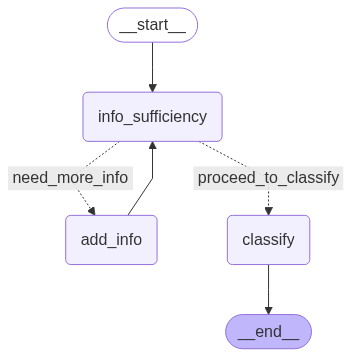

In [36]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

Вызов агента в данной "пробной" версии был через цикл, затем это было оформлено в отдельную функцию вызова.

In [37]:
results = []
num = val_data.shape[0]

for i in tqdm(range(num)):
    initial_state: AgentState = {
        "user_query": val_data['text'].iloc[i], 
        "organization_address": val_data['address'].iloc[i], 
        "organization_name": val_data['name'].iloc[i], 
        "summary": val_data['summarized'].iloc[i], 
        "sufficiency": [], 
        "classification": "", 
        "additional_info": "",
        "number_of_requests": 0, 
        "subject_of_clarification": "", 
        "search_query": ""
    }
    
    result = app.invoke(initial_state)

    # Сохраняем нужные поля в словарь
    results.append({
        "address": result["organization_address"],
        "name": result["organization_name"],
        "sufficiency": result["sufficiency"],
        "classification": result["classification"],
        "additional_info": result["additional_info"],
        "subject_of_clarification": result["subject_of_clarification"],
        "search_query": result["search_query"]
    })

  0%|          | 0/100 [00:00<?, ?it/s]

**Смотрим результаты работы агента**

In [38]:
df = pd.DataFrame(results)

In [39]:
df['agent_cls'] = np.where(df['classification'].str.contains('irrelevant'), 0, 1)

In [40]:
merged_df = pd.merge(val_data, df, on=['address', 'name'], how='inner')

In [41]:
merged_df

,text,address,name,relevance,summarized,sufficiency,classification,additional_info,subject_of_clarification,search_query,agent_cls
0,макароны из фундучной муки,"Смоленск, улица Кутузова, 54",Metro; Metro Cash & Carry; Metro Cash &amp; Ca...,0,Продуктовый гипермаркет ; Продуктовый гипермар...,"[НЕДОСТАТОЧНО: не указано, есть ли в ассортиме...",irrelevant,Ответ Tavily: Metro Cash & Carry offers a wide...,"не указано, есть ли в ассортименте макароны из...",ассортимент макарон Metro Cash & Carry,0
1,рейтинг суши баров,"Москва, Новодмитровская улица, 1с6",Такеши; Takeshi; Суши бар Takeshi; Суши-бар Та...,1,Суши-бар ; Суши-бар «Такеши» предлагает широки...,[ДОСТАТОЧНО],relevant,,,,1
2,Доставка цветов и букетов,"Краснодар, Восточно-Кругликовская улица, 72",101 Роза; 101 Rose,1,Доставка цветов и букетов ; Магазин «101 Роза»...,[ДОСТАТОЧНО],relevant,,,,1
3,итальянский ресторанчики,"Москва, Театральный проезд, 5, стр. 1",Osteria Mario; Osteria Mario Остерия Марио в Ц...,1,Ресторан ; Osteria Mario предлагает широкий вы...,[ДОСТАТОЧНО],relevant,,,,1
4,судак гостиницы,"Республика Крым, Судак, улица Сары-Кая, 5",Qirim; Гостевой дом Qirim; Крым; Gostevoi dom ...,0,Гостиница ; Предлагает размещение в гостинице ...,[ДОСТАТОЧНО],relevant,,,,1
...,...,...,...,...,...,...,...,...,...,...,...
95,Справка оружие,"Москва, Шипиловский проезд, 43, корп. 1",Наш Доктор; Nash doktor; Наш доктор,0,"Медицинская комиссия ; Медицинская комиссия, с...",[НЕДОСТАТОЧНО: отсутствует информация о выдаче...,relevant,Ответ Tavily: Наш Доктор в Москве предоставляе...,отсутствует информация о выдаче справок на оружие,Наш Доктор Москва справки на оружие,1
96,кафе уютные,"Москва, Производственная улица, 1А, стр. 1",Самарканд; Samarkand,1,Кафе ; ; ; Организация занимается подачей блюд...,[ДОСТАТОЧНО],relevant,,,,1
97,самый близкий минимаркет,"Санкт-Петербург, Смоленская улица, 3-5",Минимаркет; Minimarket; Мини-маркет,1,Супермаркет ; ; ; Организация занимается розни...,[ДОСТАТОЧНО],relevant,,,,1
98,кафе грузинской кухни в москве,"Москва, улица Маросейка, 6-8с1",Натахтари; Natakhtari; Natahtari,0,Кафе ; Кафе «Натахтари» предлагает разнообразн...,[ДОСТАТОЧНО],relevant,,,,1


In [42]:
merged_df.to_excel('result_some_agent.xlsx')

accuracy в данном случае не смотрим, т.к. это валидационный набор данных (без хорошей разметки). тут более интересно оценить сами запросы и в каких случаях они делаются.

**Выводы**

Агент может формировать запросы и пользоваться поиском.  
Вместе с тем, как показывает данный валидационный набор (так и другие val_data) данная модель LLM (deepseek-chat-v3-0324) не всегда верно формирует запросы, а также (по опыту других данных) не всегда верно следует инструкции из промпта. Частая ошибка, в том, что иногда по профилю организации ясно, что она не соответствует запросу, но, агент все равно делает уточнение. Тем самым возникают лишние и иногда некорректные запросы с аналогичным ответом от Tavily.  
Для данной модели нужны более четкие (но не избыточные) инструкции в промпте. Это будет реализовано в следующих версиях агента.  
Также в ходе экспериментов, стало ясно, что огромное значение имеет и сама модель LLM. Для подобного рода задач следует выбирать модели с высокими способностями понимать и следовать инструкциям. Этот фактор также будет учтен в следующих версиях агента.